# Control Tutorial_5
_Reference : The Control Handbook, Control System Fundamentals, Edited by William S.Levine from p9-70 to p9-73_

# PID control
---
In a PID controller the control action is generated as a sum of three terms. The control law is thus described as:

$$
u(t) = u_P(t) + u_I(t) + u_D(t)
$$

Where, $u_P(t)$ is the propotional part, $u_I(t)$ is the integral part, $u_D(t)$ is the derivative part.

### Proportional Control
The proportional control is a simple feedback

$$
u_P(t) = Ke(t)
$$

Where, $e$ is control error, and $K$ is the control gain. The error is defined as the between the set point $y_{sp}$ and the process output $y$,

$$
e(t) = y_{sp}(t) - y(t)
$$


### Integral Control
Proportional control normally gives a system that has a steady-state error. Integral action is introduced to remove this. Integral action has the form

$$
u_I(t) = k_i\int^t e(s)ds = \frac{K}{T_i}\int^te(s)ds
$$

Where, $T_i$ is the integral time constant.


### Derivative Control
Derivative control is used to provide anticipative action. A simple form is 

$$
u_D(t) = k_d\frac{de(t)}{dt} = KT_d\frac{de(t)}{dt}
$$

Where, $T_d$ is the derivative time constant.


## The control law
---
Therefore, the PID control law is described as

$$
u(t) = K_pe(t) + k_i\int^t e(s)ds + k_d\frac{de(t)}{dt} = Ke(t) + \frac{K}{T_i}\int^te(s)ds + KT_d\frac{de(t)}{dt}
$$

Also, the block diagram has the form:

<img src="figures/PID.png" hight="170">

The transfer function of the PID controller has the form

$$
C(s) = \frac{U(s)}{E(s)} = K \left( 1 + \frac{1}{T_is} + T_ds \right) = K\frac{T_iT_ds^2+T_is+1}{T_is}
$$

# Simulation (Using transfer function)

In [1]:
from scipy import signal
import sympy as sy
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interactive
from IPython.display import display
%matplotlib inline

In [2]:
def PID_controller(K,T_i,T_d):
    num = [K*T_i*T_d, K*T_i, K] 
    den = [T_i, 0] 
    return signal.lti(num, den)

Scipy does not supply the functionality for multiplying transfer functions. An alternative is converting the LTI system into a Sympy rational function.

In [3]:
def lti_to_sympy(lsys, symplify=True):
    """ Convert Scipy's LTI instance to Sympy expression """
    s = sy.Symbol('s')
    G = sy.Poly(lsys.num, s) / sy.Poly(lsys.den, s)
    return sy.simplify(G) if symplify else G

def sympy_to_lti(xpr, s=sy.Symbol('s')):
    """ Convert Sympy transfer function polynomial to Scipy LTI """
    num, den = sy.simplify(xpr).as_numer_denom()  # expressions
    p_num_den = sy.poly(num, s), sy.poly(den, s)  # polynomials
    c_num_den = [sy.expand(p).all_coeffs() for p in p_num_den]  # coefficients
    l_num, l_den = [sy.lambdify((), c)() for c in c_num_den]  # convert to floats
    return signal.lti(l_num, l_den)

## Example (Mass-Spring-Damper system)
<img src="figures/MSD_system.png" hight="150">
We try to control a simple second order system, Mass-Spring-Damper system using PID control.
The transfer function of this system is given by: (see Control Tutorial_2)

$$
G(s) = \frac{Y(s)}{X(s)} = \frac{1}{ms^2+cs+k} = \frac{\frac{1}{m}}{s^2+\frac{c}{m}s+\frac{k}{m}}
$$

In addition, the transfer function of the closed-loop $H(s)$ is given by:

$$
H(s)=\frac{C(s)G(s)}{1+C(s)G(s)}
$$

The typical parameters of Mass-Spring-Damper system setup are selected as following:  
Mass of the cart:  $m  = 1$ [kg]  
The spring constant: $k = 1$ [N/m]  
The damping constant: $c = 1$ [N/(m/s)]

We set the step function as a set point $y_{sp}$. 

In [4]:
def MSD_plant(m=1,k=1,c=1):
    num = [1/m] 
    den = [1, c/m, k/m] 
    return signal.lti(num, den)

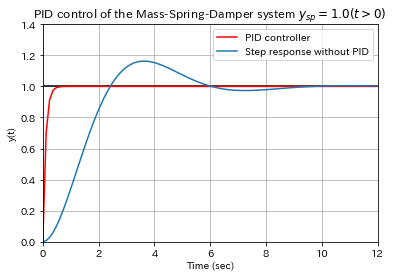

In [5]:
def PID_plot(K=10,T_i=1.0,T_d=1.0):
    
    # Multiply transfer function
    C = PID_controller(K,T_i,T_d)
    G = MSD_plant()
    Cs, Gs = lti_to_sympy(C), lti_to_sympy(G)
    Hs = sy.simplify(Cs*Gs / (1+Cs*Gs)).expand()
    H = sympy_to_lti(Hs)
    
    # Reference value is Step function
    horizon = np.linspace(0, 12, 100)
    t, y = signal.step(H, T=horizon)
    t, y2 = signal.step(G, T=horizon)
    plt.axhline(y=1,color="k")
    plt.plot(t,y,"r" ,label="PID controller")
    plt.plot(t,y2, label="Step response without PID")
    plt.title("PID control of the Mass-Spring-Damper system $y_{sp}=1.0(t>0)$")
    plt.ylabel("y(t)")
    plt.xlabel("Time (sec)")
    plt.xlim(0, 12)
    plt.ylim(0, 1.4)
    plt.grid(True)
    plt.legend()
    plt.show()
    
interactive_plot = interactive(PID_plot, K=(0 , 20 , 0.5) , T_i=(0.1, 10, 0.1), T_d=(0.0, 1.5, 0.1))
output = interactive_plot.children[-1]
output.layout.width = '600px'
interactive_plot

### When $K$ is increased, 
Advantage
- Minimize rise time

Disadvantage
- More likely to generate overshoot
- Lengthen the setting time

### When $K$ is decreased, 
Advantage
- Minimize overshoot

Disadvantage
- Lengthen the setting time
- Increase offset

### When $T_i$ is increased, 
Advantage
- Minimize overshoot and hunting

Disadvantage
- Lengthen rise time

### When $T_i$ is decreased, 
Advantage
- Minimize rise time

Disadvantage
- More likely to generate hunting, overshoot, and undershoot.
- Lengthen the setting time

### When $T_d$ is increased, 
Advantage
- Minimize overshoot

Disadvantage
- More likely to generate hunting

### When $T_d$ is decreased, 
Advantage
- Provide responsiveness for the disturbances

Disadvantage
- More likely to be affected by the disturbances